In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('gtdcsv.csv', delimiter='|')

In [4]:
df

,country_txt,region_txt,provstate,city,attacktype1_txt,targtype1_txt,targsubtype1_txt,natlty1_txt,weaptype1_txt,weapsubtype1_txt,...,nkillus,nwound,propextent,region,success,suicide,targsubtype1,weapsubtype1,weaptype1,targtype1
0,Burundi,Sub-Saharan Africa,Bujumbura Mairie,Bujumbura,Armed Assault,Military,"Military Personnel (soldiers, troops, officers...",Burundi,Firearms,Unknown Gun Type,...,0,6,-1,11,True,False,34,5,5,4
1,Russia,Eastern Europe,Moscow,Moscow,Bombing/Explosion,Transportation,Subway,Russia,Explosives,Time Fuse,...,0,3,-1,9,True,False,102,14,6,19
2,United Kingdom,Western Europe,Northern Ireland,Belfast,Armed Assault,Private Citizens & Property,Named Civilian,Northern Ireland,Firearms,Automatic or Semi-Automatic Rifle,...,0,0,-1,8,True,False,68,2,5,14
3,Iraq,Middle East & North Africa,Baghdad,Baghdad,Bombing/Explosion,Government (Diplomatic),"International Organization (peacekeeper, aid a...",Multinational,Explosives,"Projectile (rockets, mortars, RPGs, etc.)",...,0,0,3,10,True,False,47,11,6,7
4,West Bank and Gaza Strip,Middle East & North Africa,West Bank,Unknown,Armed Assault,Private Citizens & Property,Race/Ethnicity Identified,Israel,Firearms,Automatic or Semi-Automatic Rifle,...,0,1,-1,10,False,False,71,2,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139150,Yemen,Middle East & North Africa,Al Hudaydah,Sabaa,Bombing/Explosion,Private Citizens & Property,House/Apartment/Residence,Yemen,Explosives,"Projectile (rockets, mortars, RPGs, etc.)",...,0,-1,3,10,True,False,76,11,6,14
139151,Yemen,Middle East & North Africa,Al Hudaydah,Beit Maghari,Bombing/Explosion,Private Citizens & Property,House/Apartment/Residence,Yemen,Explosives,Landmine,...,0,-1,-1,10,True,False,76,8,6,14
139152,Germany,Western Europe,Lower Saxony,Leipzig,Facility/Infrastructure Attack,Military,Military Transportation/Vehicle (excluding con...,Germany,Incendiary,Arson/Fire,...,0,0,4,8,True,False,35,18,8,4
139153,Afghanistan,South Asia,Kabul,Kabul,Armed Assault,Private Citizens & Property,Protester,Afghanistan,Firearms,Unknown Gun Type,...,0,0,-1,6,True,False,83,5,5,14


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
df = df[['iyear','imonth','iday','nkill','nkillter','nwound','nhostkid']]
df = df.replace(-1, 0)
df = df.replace(-99,0)
df

,iyear,imonth,iday,nkill,nkillter,nwound,nhostkid
0,1998,1,1,104,100,6,0
1,1998,1,1,0,0,3,0
2,1998,1,1,1,0,0,0
3,1998,1,2,0,0,0,0
4,1998,1,2,0,0,1,0
...,...,...,...,...,...,...,...
139150,2020,12,31,0,0,0,0
139151,2020,12,31,0,0,0,0
139152,2020,12,31,0,0,0,0
139153,2020,12,31,1,0,0,0


In [7]:
def date_transform(month, year):
    return (year-1998)*12 + month - 1

def reverse_scaling(y, x):
    num = y[0][0]
    max_num = x.max()
    min_num = x.min()
    return num*(max_num-min_num)+min_num

In [8]:
df['date_trans'] = df[['imonth', 'iyear']].apply(lambda row: date_transform(row['imonth'], row['iyear']), axis=1)
df

,iyear,imonth,iday,nkill,nkillter,nwound,nhostkid,date_trans
0,1998,1,1,104,100,6,0,0
1,1998,1,1,0,0,3,0,0
2,1998,1,1,1,0,0,0,0
3,1998,1,2,0,0,0,0,0
4,1998,1,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...
139150,2020,12,31,0,0,0,0,275
139151,2020,12,31,0,0,0,0,275
139152,2020,12,31,0,0,0,0,275
139153,2020,12,31,1,0,0,0,275


In [9]:
nkill_sum = df.groupby('date_trans')['nkill'].sum()
nwound_sum = df.groupby('date_trans')['nwound'].sum()
nkillter_sum = df.groupby('date_trans')['nkillter'].sum()
nhostkid_sum = df.groupby('date_trans')['nhostkid'].sum()
fact_sum = df['date_trans'].value_counts()
att_list = [fact_sum.sort_index(),nkill_sum.sort_index(), nwound_sum.sort_index(), nkillter_sum.sort_index(), nhostkid_sum.sort_index()]
df = pd.DataFrame(att_list).T
df.columns = ['fact_sum','nkill','nwound','nkillter','nhostkid']
df

,fact_sum,nkill,nwound,nkillter,nhostkid
0,80,464,184,157,4
1,94,754,545,321,46
2,62,278,644,20,196
3,65,296,198,57,60
4,53,122,340,4,30
...,...,...,...,...,...
271,706,1785,1306,570,415
272,765,1860,1221,554,369
273,726,1939,1611,627,286
274,635,2562,1424,598,1360


In [10]:
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [11]:
xtrain_nkill = df_scaled.loc[:273,'nkill'].values.reshape(-1,1)
ytrain_nkill = df_scaled.loc[274,'nkill']
xtest_nkill = df_scaled.loc[1:274,'nkill'].values.reshape(-1,1)
ytest_nkill = df_scaled.loc[275,'nkill']
ytrain_nkill=np.array([ytrain_nkill]).reshape(-1,1)
ytest_nkill=np.array([ytest_nkill]).reshape(-1,1)

In [12]:
xtrain_nkillter = df_scaled.loc[:273,'nkillter'].values.reshape(-1,1)
ytrain_nkillter = df_scaled.loc[274,'nkillter']
xtest_nkillter = df_scaled.loc[1:274,'nkillter'].values.reshape(-1,1)
ytest_nkillter = df_scaled.loc[275,'nkillter']
ytrain_nkillter=np.array([ytrain_nkillter]).reshape(-1,1)
ytest_nkillter=np.array([ytest_nkillter]).reshape(-1,1)

In [13]:
xtrain_nwound = df_scaled.loc[:273,'nwound'].values.reshape(-1,1)
ytrain_nwound = df_scaled.loc[274,'nwound']
xtest_nwound = df_scaled.loc[1:274,'nwound'].values.reshape(-1,1)
ytest_nwound = df_scaled.loc[275,'nwound']
ytrain_nwound=np.array([ytrain_nwound]).reshape(-1,1)
ytest_nwound=np.array([ytest_nwound]).reshape(-1,1)

In [14]:
xtrain_nhostkid = df_scaled.loc[:273,'nhostkid'].values.reshape(-1,1)
ytrain_nhostkid = df_scaled.loc[274,'nhostkid']
xtest_nhostkid = df_scaled.loc[1:274,'nhostkid'].values.reshape(-1,1)
ytest_nhostkid = df_scaled.loc[275,'nhostkid']
ytrain_nhostkid=np.array([ytrain_nhostkid]).reshape(-1,1)
ytest_nhostkid=np.array([ytest_nhostkid]).reshape(-1,1)

In [15]:
xtrain_fact_sum = df_scaled.loc[:273,'fact_sum'].values.reshape(-1,1)
ytrain_fact_sum = df_scaled.loc[274,'fact_sum']
xtest_fact_sum = df_scaled.loc[1:274,'fact_sum'].values.reshape(-1,1)
ytest_fact_sum = df_scaled.loc[275,'fact_sum']
ytrain_fact_sum=np.array([ytrain_fact_sum]).reshape(-1,1)
ytest_fact_sum=np.array([ytest_fact_sum]).reshape(-1,1)

In [16]:
xtrain_nkill = np.expand_dims(xtrain_nkill, 0)
xtest_nkill = np.expand_dims(xtest_nkill, 0)

xtrain_nkillter = np.expand_dims(xtrain_nkillter, 0)
xtest_nkillter = np.expand_dims(xtest_nkillter, 0)

xtrain_nwound = np.expand_dims(xtrain_nwound, 0)
xtest_nwound = np.expand_dims(xtest_nwound, 0)

xtrain_nhostkid = np.expand_dims(xtrain_nhostkid, 0)
xtest_nhostkid = np.expand_dims(xtest_nhostkid, 0)

xtrain_fact_sum = np.expand_dims(xtrain_fact_sum, 0)
xtest_fact_sum = np.expand_dims(xtest_fact_sum, 0)

In [17]:
model_nkill = Sequential()
model_nkill.add(LSTM(units=128, input_shape=(274, 1)))
model_nkill.add(Dense(units=64,activation='relu'))
model_nkill.add(Dropout(0.2))
model_nkill.add(Dense(units=1,activation='relu'))

In [18]:
model_nkillter = Sequential()
model_nkillter.add(LSTM(units=128, input_shape=(274, 1)))
model_nkillter.add(Dense(units=64,activation='relu'))
model_nkillter.add(Dropout(0.2))
model_nkillter.add(Dense(units=1,activation='relu'))

In [19]:
model_nwound = Sequential()
model_nwound.add(LSTM(units=128, input_shape=(274, 1)))
model_nwound.add(Dense(units=64,activation='relu'))
model_nwound.add(Dropout(0.2))
model_nwound.add(Dense(units=1,activation='relu'))

In [20]:
model_nhostkid = Sequential()
model_nhostkid.add(LSTM(units=128, input_shape=(274, 1)))
model_nhostkid.add(Dense(units=64,activation='relu'))
model_nhostkid.add(Dropout(0.2))
model_nhostkid.add(Dense(units=1,activation='relu'))

In [21]:
model_fact_sum = Sequential()
model_fact_sum.add(LSTM(units=128, input_shape=(274, 1)))
model_fact_sum.add(Dense(units=64,activation='elu'))
model_fact_sum.add(Dropout(0.2))
model_fact_sum.add(Dense(units=1,activation='elu'))
model_fact_sum.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [22]:
learning_rate = 0.0007  # Giá trị learning rate ban đầu
optimizer1 = Adam(learning_rate=learning_rate)
optimizer2 = Adam(learning_rate=learning_rate)
optimizer3 = Adam(learning_rate=learning_rate)
optimizer4 = Adam(learning_rate=learning_rate)
optimizer5 = Adam(learning_rate=learning_rate)

In [23]:
model_nkill.compile(loss='mse',optimizer=optimizer1,metrics=['accuracy'])

In [24]:
model_nkillter.compile(loss='mse',optimizer=optimizer2,metrics=['accuracy'])

In [25]:
model_nwound.compile(loss='mse',optimizer=optimizer3,metrics=['accuracy'])

In [26]:
model_nhostkid.compile(loss='mse',optimizer=optimizer4,metrics=['accuracy'])

In [27]:
model_fact_sum.compile(loss='mse',optimizer=optimizer5,metrics=['accuracy'])

In [28]:
history_nkill = model_nkill.fit(xtrain_nkill, ytrain_nkill, epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.1488 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 66ms/step - loss: 0.1466 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 53ms/step - loss: 0.1305 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 53ms/step - loss: 0.1288 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 57ms/step - loss: 0.1045 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 55ms/step - loss: 0.0941 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 56ms/step - loss: 0.0635 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 56ms/step - loss: 0.0646 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 53ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 54ms/step - loss: 0.0695 - accuracy: 0.

In [29]:
history_nkillter = model_nkillter.fit(xtrain_nkillter, ytrain_nkillter, epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 49ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 83ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 78ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 47ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 47ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 48ms/step - loss: 0.2110 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 46ms/step - loss: 0.2110 - accuracy: 0.

In [30]:
history_nwound = model_nwound.fit(xtrain_nwound, ytrain_nwound, epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 77ms/step - loss: 0.0011 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 76ms/step - loss: 3.6746e-04 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 85ms/step - loss: 2.2551e-04 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 88ms/step - loss: 1.9493e-04 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 55ms/step - loss: 1.8628e-04 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 69ms/step - loss: 8.7414e-05 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 63ms/step - loss: 7.2245e-04 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 76ms/step - los

In [31]:
history_nhostkid = model_nhostkid.fit(xtrain_nhostkid, ytrain_nhostkid, epochs=50)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.0348 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 76ms/step - loss: 0.0290 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 75ms/step - loss: 0.0254 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 93ms/step - loss: 0.0226 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 81ms/step - loss: 0.0139 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 86ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 73ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 79ms/step - loss: 7.2934e-04 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 78ms/step - loss: 4.2352e-04 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 84ms/step - loss: 0.0051 - accu

In [32]:
history_fact_sum = model_fact_sum.fit(xtrain_fact_sum, ytrain_fact_sum, epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.1735 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 0.1157 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0503 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 50ms/step - loss: 0.0515 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 44ms/step - loss: 0.0296 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 54ms/step - loss: 6.8174e-05 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 63ms/step - loss: 0.0021 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 62ms/step - loss: 0.0138 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0190 - accuracy

In [33]:
ypred_nkill = model_nkill.predict(xtest_nkill)
ypred_nkillter = model_nkillter.predict(xtest_nkillter)
ypred_nwound = model_nwound.predict(xtest_nwound)
ypred_nhostkid = model_nhostkid.predict(xtest_nhostkid)
ypred_fact_sum = model_fact_sum.predict(xtest_fact_sum)

1/1 [==============================] - 0s 358ms/step


In [34]:
ypred = np.array([])
ypred = np.append(ypred, int(reverse_scaling(ypred_nkill,df.loc[:,'nkill'].values)))
ypred = np.append(ypred, int(reverse_scaling(ypred_nkillter,df.loc[:,'nkillter'].values)))
ypred = np.append(ypred, int(reverse_scaling(ypred_nwound,df.loc[:,'nwound'].values)))
ypred = np.append(ypred, int(reverse_scaling(ypred_nhostkid,df.loc[:,'nhostkid'].values)))
ypred = np.append(ypred, int(reverse_scaling(ypred_fact_sum,df.loc[:,'fact_sum'].values)))
ytrue = np.array([])
ytrue = np.append(ytrue, int(reverse_scaling(ytest_nkill,df.loc[:,'nkill'].values)))
ytrue = np.append(ytrue, int(reverse_scaling(ytest_nkillter,df.loc[:,'nkillter'].values)))
ytrue = np.append(ytrue, int(reverse_scaling(ytest_nwound,df.loc[:,'nwound'].values)))
ytrue = np.append(ytrue, int(reverse_scaling(ytest_nhostkid,df.loc[:,'nhostkid'].values)))
ytrue = np.append(ytrue, int(reverse_scaling(ytest_fact_sum,df.loc[:,'fact_sum'].values)))

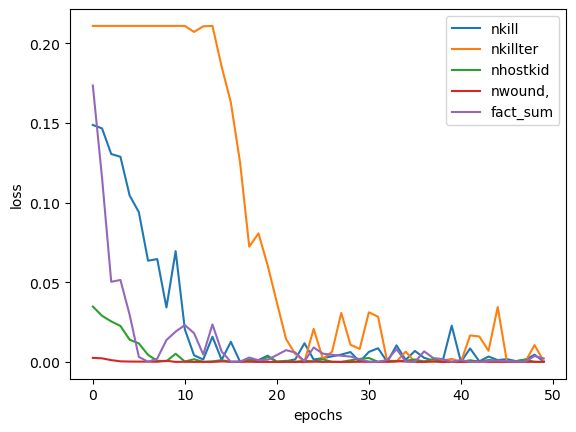

In [ ]:
epochs = list(range(50))
loss_nkill = history_nkill.history['loss']
loss_nkillter = history_nkillter.history['loss']
loss_nhostkid = history_nhostkid.history['loss']
loss_nwound = history_nwound.history['loss']
loss_fact_sum = history_fact_sum.history['loss']

plt.plot(epochs, loss_nkill, label='nkill')
plt.plot(epochs, loss_nkillter, label='nkillter')
plt.plot(epochs, loss_nhostkid, label='nhostkid')
plt.plot(epochs, loss_nwound, label='nwound,')
plt.plot(epochs, loss_fact_sum, label='fact_sum')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
result_lstm_df = pd.DataFrame({
    'Prediction': ypred,
    'True': ytrue
})
lstm_df_melted = result_lstm_df.melt(var_name='Group', value_name='Value')
lstm_df_melted['Type']=['Nkill','Nkillter','Nwound','Nhostkid','Fact_Sum']*2
lstm_df_melted

,Group,Value,Type
0,Prediction,2456.0,Nkill
1,Prediction,581.0,Nkillter
2,Prediction,1553.0,Nwound
3,Prediction,1341.0,Nhostkid
4,Prediction,613.0,Fact_Sum
5,True,1698.0,Nkill
6,True,574.0,Nkillter
7,True,1108.0,Nwound
8,True,356.0,Nhostkid
9,True,622.0,Fact_Sum


<Axes: xlabel='Type', ylabel='Value'>

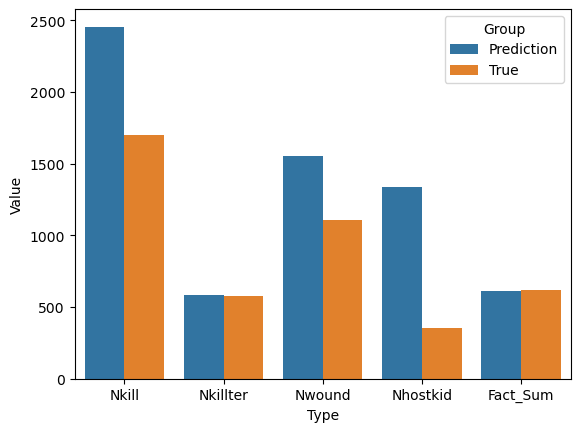

In [41]:
sns.barplot(x='Type', y='Value', hue='Group', data=lstm_df_melted)